In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 준비

In [2]:
!pip install transformers==4.27 torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00


In [ ]:
!pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torch import nn
import torch

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

#def image_list(dir): # 이미지 데이터 가져오기
#    imagelist=[]
#    for i in range(len(os.listdir(dir))):
#        path = dir+'/image'+str(i+1)+'.jpg'
#        imagelist.append(Image.open(path))
#    return imagelist

In [ ]:
# from transformers import BlipProcessor, BlipForConditionalGeneration
# processor = BlipProcessor.from_pretrained('preprocessor_path')
# model = BlipForConditionalGeneration.from_pretrained("model_path")

In [ ]:
# from transformers import BlipProcessor, BlipForConditionalGeneration
# mode = "Salesforce/blip-image-captioning-base"
# processor = BlipProcessor.from_pretrained('/content/drive/MyDrive/mjae/configs/preprocessor')
# model = BlipForConditionalGeneration.from_pretrained(mode)

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained('/content/drive/MyDrive/mjae/configs/preprocessor')
model = BlipForConditionalGeneration.from_pretrained(mode)

In [ ]:
from transformers import Swin2SRImageProcessor, Swin2SRForImageSuperResolution

pro_sr = Swin2SRImageProcessor.from_pretrained("caidas/swin2SR-lightweight-x2-64")
model_sr = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64")

In [ ]:
option = {
    'start': 0,
    'num': 25000,
    'batch_size':16,
}

In [ ]:
def image_list(dir, captions):
    imagelist = []
    for item in captions:
        image_name = item['image']
        path = os.path.join(dir, image_name)
        imagelist.append(Image.open(path))
    return imagelist

In [ ]:
#zip 풀기
!unzip -qq '/content/drive/MyDrive/mjae/export/image_augmented.zip' -d '/content'

In [ ]:
labelpath="/content/drive/MyDrive/mjae/annotaions/shuffled_captions.json"
with open(labelpath, 'r',encoding = 'utf-8' or 'cp949' ) as f: # json 파일 접근
    captions = json.load(f)

In [ ]:
def image_list_with_sr(captions,dir,n,m): # 이미지 데이터 가져오기
    imagelist=[]
    for i in range(n,n+m):
        path = dir+'/'+captions[i]['image']
        image = Image.open(path)
        image = super_reso(image) if image.size[0]<50 or image.size[1]<100 else image
        imagelist.append(image)
    return imagelist

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_sr.to(device)
def super_reso(image):
    inputs = pro_sr(image, return_tensors="pt").to(device)

    # forward pass
    with torch.no_grad():
        outputs = model_sr(**inputs)

    output = outputs.reconstruction.data.squeeze().cpu().float().clamp_(0, 1).numpy()
    output = np.moveaxis(output, source=0, destination=-1)
    output = (output * 255.0).round().astype(np.uint8)
    return Image.fromarray(output)

In [ ]:
import numpy as np

In [ ]:
ImageList = image_list_with_sr(captions,'/content/image_augmented',option['start'],option['num'])
model_sr.to('cpu') # 25000장에서 약 3.5분 소요

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(60, 60, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-3): 4 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (query):

In [ ]:
#ImageList = image_list('/content/5000_final_prepro',captions)

In [ ]:
# import torch
# import numpy as np
# from PIL import Image

# from transformers import Swin2SRImageProcessor, Swin2SRForImageSuperResolution

# processor2 = Swin2SRImageProcessor.from_pretrained("caidas/swin2SR-lightweight-x2-64")
# model2 = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64")

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model2.to(device)

# for i in range(len(ImageList)):
#     image = ImageList[i]

#     # Check if image size is smaller than 70x100
#     if image.size[0] < 50 or image.size[1] < 100:
#       # Prepare image for the model
#       inputs = processor2(image, return_tensors="pt").to(device)

#       # Forward pass
#       with torch.no_grad():
#           outputs = model2(**inputs)

#       output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
#       output = np.moveaxis(output, source=0, destination=-1)
#       output = (output * 255.0).round().astype(np.uint8)  # Convert float32 to uint8

#       # Replace the original image in the imagelist with the transformed image
#       ImageList[i] = Image.fromarray(output)

In [ ]:
data = [{'text':captions[i]['label'],'image':ImageList[i]} for i in range(option['start'],option['start']+option['num'])]

In [ ]:
# train_dataloader = DataLoader(ImageCaptioningDataset(data[:4000], processor), shuffle=False, batch_size=8)
# val_dataloader = DataLoader(ImageCaptioningDataset(data[4000:], processor), shuffle=False, batch_size=8)

In [ ]:
train_dataset = ImageCaptioningDataset(data[:int(0.8*option['num'])], processor)
val_dataset = ImageCaptioningDataset(data[int(0.8*option['num']):], processor)
train_dataloader = DataLoader(train_dataset,shuffle=False,batch_size = option['batch_size'])
val_dataloader = DataLoader(val_dataset,shuffle=False,batch_size = option['batch_size'])

In [ ]:
len(train_dataloader), len(val_dataloader)

(1250, 313)

### 성능지표 코드

In [ ]:
def gen_captions(captions,filename):
    gen = []
    for i in range(len(captions)):
        gen.append({'image_id': i+1, 'caption': captions[i]})

    with open(filename,'w') as f:
      json.dump(gen,f)

In [ ]:
# def make_gt(captions,filename):
#     annotations=[]
#     images = []
#     for i in range(len(captions)):
#         annotations.append({'image_id': i+1, 'caption': captions[i],'id': i+1})
#         images.append({'id':i+1})
#     gt_captions ={
#         'annotations': annotations,
#         'images': images
#     }
#     with open(filename,'w') as f:
#       json.dump(gt_captions,f)

In [ ]:
import json
import os
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

def coco_caption_eval(annotation_file, results_file):

    coco = COCO(annotation_file)
    coco_result = coco.loadRes(results_file)

    coco_eval = COCOEvalCap(coco, coco_result)
    coco_eval.evaluate()

    # print output evaluation scores
    for metric, score in coco_eval.eval.items():
        print(f'{metric}: {score:.3f}')

    return coco_eval

In [ ]:
import torch
val_cpath = '/content/drive/MyDrive/mjae/output/val'
val_rpath = '/content/drive/MyDrive/mjae/output/gt_captions.json'
train_hist=[]
val_hist=[]
train_iter_hist=[]
val_iter_hist = []
#val_eval = []

In [ ]:
# make_gt([item['text'] for item in data][:4000],train_rpath) # train의 진짜 caption
# make_gt([item['text'] for item in data][4000:],val_rpath)#val의 진짜 caption

### Finetuning

In [ ]:
print(model)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
# for name, param in model.named_parameters():
#     param.requires_grad = False

In [ ]:
# model.text_decoder.bert.encoder.layer

In [ ]:
# n = 0
# for l in model.text_decoder.bert.encoder.layer:
#   n += 1
#   if n >= 12:
#     l.crossattention.requires_grad_()
#   else:
#     continue

In [ ]:
# model.text_decoder.cls.predictions.decoder.requires_grad_()

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, "is trainable")
    else:
        print(name, "is frozen")

vision_model.embeddings.class_embedding is trainable
vision_model.embeddings.position_embedding is trainable
vision_model.embeddings.patch_embedding.weight is trainable
vision_model.embeddings.patch_embedding.bias is trainable
vision_model.encoder.layers.0.self_attn.qkv.weight is trainable
vision_model.encoder.layers.0.self_attn.qkv.bias is trainable
vision_model.encoder.layers.0.self_attn.projection.weight is trainable
vision_model.encoder.layers.0.self_attn.projection.bias is trainable
vision_model.encoder.layers.0.layer_norm1.weight is trainable
vision_model.encoder.layers.0.layer_norm1.bias is trainable
vision_model.encoder.layers.0.mlp.fc1.weight is trainable
vision_model.encoder.layers.0.mlp.fc1.bias is trainable
vision_model.encoder.layers.0.mlp.fc2.weight is trainable
vision_model.encoder.layers.0.mlp.fc2.bias is trainable
vision_model.encoder.layers.0.layer_norm2.weight is trainable
vision_model.encoder.layers.0.layer_norm2.bias is trainable
vision_model.encoder.layers.1.self_

In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

lr = 1e-6
E = 30

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=E)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(E):
    model.train()
    Loss = 0

    #train_caption = []
    for idx, batch in enumerate(train_dataloader):
        model.train()
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        outputs = model(input_ids=input_ids,pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #성능을 보기 위한 작업

        #with torch.no_grad():
        #  model.eval()
        #  train_caption+=processor.batch_decode(model.generate(pixel_values=pixel_values,max_length = 100),skip_special_tokens=True)
        Loss+=loss.tolist()
        #train_hist2.append(loss.tolist())

    train_hist.append(Loss/len(train_dataloader))


    #validation진행
    val = 0
    val_caption =[]
    with torch.no_grad():
        model.eval()
        for idx, batch in enumerate(val_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            outputs = model(input_ids=input_ids,pixel_values=pixel_values, labels=input_ids)

            #성능을 보기위한 작업
            val_caption+=processor.batch_decode(model.generate(pixel_values=pixel_values,max_length = 300),skip_special_tokens=True)
            val+=outputs.loss.tolist()

    val_hist.append(val/len(val_dataloader))

    #checkpoint
    if val_hist[-1]==min(val_hist):
        torch.save(model,'/content/drive/MyDrive/mjae/model_zoo/blip_all_1e6_final.pt')

    #Epoch 출력
    print("Epoch {}회차 - val_Loss:{}, ".format(epoch+1,val/313))

    #epoch의 caption들 저장 및 성능 출력을 위한 코드들
    #gen_captions(train_caption,train_cpath+'/'+str(epoch+1)+'.json')
    gen_captions(val_caption,val_cpath+'/'+str(epoch+1)+'.json')
    #train_eval.append(coco_caption_eval(train_rpath,train_cpath+'/'+str(epoch+1)+'.json').eval.items())
    #val_eval.append(coco_caption_eval(val_rpath,val_cpath+'/'+str(epoch+1)+'.json').eval.items())

Epoch 1회차 - val_Loss:5.125121256794793, 
Epoch 2회차 - val_Loss:2.461861858733546, 
Epoch 3회차 - val_Loss:1.5760467319061962, 
Epoch 4회차 - val_Loss:1.4392739694339398, 
Epoch 5회차 - val_Loss:1.4065341222019623, 
Epoch 6회차 - val_Loss:1.3955995846099365, 
Epoch 7회차 - val_Loss:1.391468008867087, 
Epoch 8회차 - val_Loss:1.3896371994536525, 
Epoch 9회차 - val_Loss:1.3887076960584988, 
Epoch 10회차 - val_Loss:1.387979251508134, 
Epoch 11회차 - val_Loss:1.3874227345561068, 
Epoch 12회차 - val_Loss:1.3869182556962814, 
Epoch 13회차 - val_Loss:1.3865453195267212, 
Epoch 14회차 - val_Loss:1.386239124944035, 
Epoch 15회차 - val_Loss:1.386021248448771, 
Epoch 16회차 - val_Loss:1.3860033247798396, 
Epoch 17회차 - val_Loss:1.3859199171249097, 
Epoch 18회차 - val_Loss:1.3858105717375637, 
Epoch 19회차 - val_Loss:1.3857783223874272, 
Epoch 20회차 - val_Loss:1.3858927663522786, 
Epoch 21회차 - val_Loss:1.3860996797823677, 
Epoch 22회차 - val_Loss:1.3861687248126386, 
Epoch 23회차 - val_Loss:1.3866220880240296, 
Epoch 24회차 - val_Loss:1.38

In [ ]:
# #from transformers.models.blip_2.modeling_blip_2 import Blip2Encoder
# save_directory = '/content/drive/MyDrive/BLIP_for_cctv/configs'
# processor.save_pretrained(save_directory=save_directory)

In [ ]:
import json
total_list =[train_hist, val_hist]
with open('/content/drive/MyDrive/mjae/output/loss_blip_all_final_plot.json','w') as f:
  json.dump(total_list,f)

# 시험

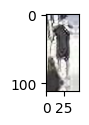

In [ ]:
k=3
image = ImageList[-k]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(1,1))
plt.imshow(image)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num=196
model.eval()
generated_ids = model.generate(pixel_values= processor(images=image, return_tensors="pt").to(device).pixel_values, max_length=70)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Epoch:{},데이터셋:{}".format(E,num))
print("캡션:",generated_caption,"사진크기:",image.size)
print("원래 정답: {}".format(captions[-k]['label']))

Epoch:5,데이터셋:196
캡션: a male adult is wearing black short sleeve top and black short pants. 사진크기: (48, 112)
원래 정답: A male adult is wearing black short sleeve top, black short pants and a bag.


In [ ]:
result_cap = []

for i in range(len(result[4001:])):
  image = ImageList[-i]
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.eval()
  generated_ids = model.generate(pixel_values= processor(images=image, return_tensors="pt").to(device).pixel_values, max_length=80)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  result_cap.append({'image':image, '원래정답':captions[-i]['label'],'생성캡션':generated_caption})

In [ ]:
result_cap

[{'image': <PIL.Image.Image image mode=RGB size=208x512 at 0x7FA8200CFBB0>,
  '원래정답': 'A female adult is wearing white short sleeve top, black short pants and a bag.',
  '생성캡션': 'a male senior is wearing white short sleeve top and black short pants.'},
 {'image': <PIL.Image.Image image mode=RGB size=144x288 at 0x7FA8201B6710>,
  '원래정답': 'A male senior is wearing blue long sleeve top and black long pants.',
  '생성캡션': 'a male senior is wearing blue short sleeve top and black long pants.'},
 {'image': <PIL.Image.Image image mode=RGB size=240x320 at 0x7FA8201B65F0>,
  '원래정답': 'A female senior is wearing purple long sleeve top, black long pants and a bag.',
  '생성캡션': 'a female senior is wearing grey long sleeve top, black long pants and a bag.'},
 {'image': <PIL.Image.Image image mode=RGB size=48x112 at 0x7FA8201B6620>,
  '원래정답': 'A male adult is wearing black short sleeve top, black short pants and a bag.',
  '생성캡션': 'a male adult is wearing black short sleeve top and black short pants.'},

In [ ]:
torch.save(model,'/content/drive/MyDrive/data/5000/blip.pt')
processor.save_pretrained('/content/drive/MyDrive/data/5000/preprocessor')

In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

E = 5

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=E)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

for epoch in range(E):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for val_batch in val_dataloader:
            val_input_ids = val_batch.pop("input_ids").to(device)
            val_pixel_values = val_batch.pop("pixel_values").to(device)
            val_outputs = model(input_ids=val_input_ids, pixel_values=val_pixel_values, labels=val_input_ids)
            val_loss = val_outputs.loss
            total_loss += val_loss.item()

        avg_val_loss = total_loss / len(val_dataloader)

    print("Epoch: {}, Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, loss.item(), avg_val_loss))

    model.train()


Epoch: 1, Loss: 1.4339, Val Loss: 1.4279
Epoch: 2, Loss: 1.3760, Val Loss: 1.3728
Epoch: 3, Loss: 1.3679, Val Loss: 1.3683
Epoch: 4, Loss: 1.3638, Val Loss: 1.3672
Epoch: 5, Loss: 1.3621, Val Loss: 1.3666
